In [1]:
import os

import pandas as pd
import numpy as np

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from sqlalchemy import func, distinct # library to use aggregate functions
from sqlalchemy.sql import operators

import seaborn as sns
import matplotlib.pyplot as plt

# plotly
import plotly.plotly as py
import plotly.offline as pyOff
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

In [2]:
# Declare global variables
dbPath = "trafficViolations/static/db"

dbName = "trafficViolations.sqlite"

In [3]:
# create the connection to SQLite db
eng = create_engine(f"sqlite:///{dbPath}/{dbName}")

In [4]:
# reflect an existing database into a new model
Base  = automap_base()

#prepare and reflect all tables wih data
Base.prepare(eng, reflect = True)

In [5]:
print(Base.classes.keys())

['traffic_violations']


In [6]:
V = Base.classes['traffic_violations']

In [7]:
# create session
session = Session(bind = eng)

In [8]:
# extract unique years
def getAllViolations_byMonth():
    sel = [V.Year, V.Month, func.sum(V.ViolationCount)]
    res = pd.DataFrame(session.query(*sel).group_by(V.Month).group_by(V.Year).all(), columns = ['Year','Month','Cnt'])
    
    return res

df = getAllViolations_byMonth()
df.head()

,Year,Month,Cnt
0,2012,1,7603
1,2013,1,9452
2,2014,1,10737
3,2015,1,11959
4,2016,1,11307


In [11]:
df = df.astype(str)
df.dtypes

Year     object
Month    object
Cnt      object
dtype: object

In [58]:
# extract unique years
def getAllViolations_byQtr():
    sel = [V.Year, V.Qtr, func.sum(V.ViolationCount)]
    res = pd.DataFrame(session.query(*sel).group_by(V.Qtr).group_by(V.Year).all(), columns = ['Year','Qtr','Cnt'])
    
    return res

dfQ = getAllViolations_byQtr()
dfQ.head()

,Year,Qtr,Cnt
0,2012,1,23268
1,2013,1,29480
2,2014,1,34673
3,2015,1,36555
4,2016,1,39279


In [70]:
def getAllViolations_byDist():
    sel = [V.Year, V.PoliceDistrictID, func.sum(V.ViolationCount)]
    res = pd.DataFrame(session.query(*sel).group_by(V.PoliceDistrictID).group_by(V.Year).all(), columns = ['Year','Dist','Cnt'])
    
    return res

dfD = getAllViolations_byDist()
dfD.head()

,Year,Dist,Cnt
0,2012,1,14936
1,2013,1,15983
2,2014,1,18790
3,2015,1,18216
4,2016,1,17460


In [38]:
df['Year'] = df['Year'].astype(str)
df['Month'] = df['Month'].astype(str)
df['Period'] = df[['Month','Year']].apply(lambda x : "-".join(x), axis=1)
df['Year'] = df['Year'].astype(int)
df['Month'] = df['Month'].astype(int)
df.Period.head(3)

0    1-2012
1    1-2013
2    1-2014
Name: Period, dtype: object

In [39]:
df.Year.unique()

array([2012, 2013, 2014, 2015, 2016], dtype=int64)

In [40]:
color = {2012:'#6666ff',2013:'#cc0099',2014:'#660033',2015:'#ff9900',2016:'#009900'}
data = []
for i in df.Year.unique():
    # Creating trace1
    data.append(go.Scatter(
                    x = df[df.Year == i].Month,
                    y = df[df.Year == i].Cnt,
                    mode = "lines",
                    name = f"Violation {i}",
                    marker = dict(color = color[i]),
                    text= str(i))
               )

In [42]:
layout = dict(title = 'Violation across months over years (2012 to 2016)',
              xaxis= dict(title= 'Months',ticklen= 5,zeroline= False)
             )

fig = dict(data = data, layout = layout)
iplot(fig)

In [44]:
color = {2012:'#6666ff',2013:'#cc0099',2014:'#660033',2015:'#ff9900',2016:'#009900'}
data = []
for i in df.Year.unique():
    # Creating trace1
    data.append(go.Box(
#                     x = df[df.Year == i].Month,
                    y = df[df.Year == i].Cnt,
#                     mode = "lines",
                    )
               )
data

[Box({
     'y': array([ 7603,  7399,  8266,  8821, 10795,  8882,  8316,  8767,  8729,
            9400,  9692,  9225], dtype=int64)
 }), Box({
     'y': array([ 9452,  9018, 11010, 10538, 11903,  9566, 11110, 11710, 12275,
           12025, 11846, 11332], dtype=int64)
 }), Box({
     'y': array([10737, 10782, 13154, 13939, 14585, 12137, 13118, 12399, 12481,
           13409, 12473, 11499], dtype=int64)
 }), Box({
     'y': array([11959, 10924, 13672, 14112, 14023, 12976, 13504, 14265, 13530,
           13548, 13430, 12352], dtype=int64)
 }), Box({
     'y': array([11307, 13138, 14834, 14133, 12933, 13510, 12191, 12448, 11667,
           12008, 11222, 10339], dtype=int64)
 })]

In [53]:
pyOff.iplot(data)

E:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



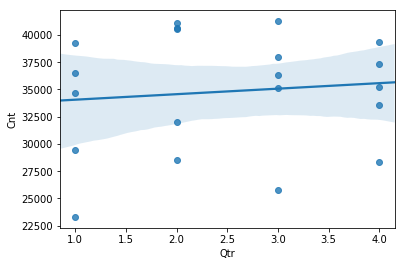

In [73]:
sns.regplot("Qtr","Cnt", data=dfQ)